## Import the required libraries

In [2]:
import os, random, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyidaungsu as pds
import re, json, pickle, joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models


import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

## Step 1: Setup & Data Load

Shape: (1024, 2)
                                                News  Category
0  တီကျစ်ကျောက် မီးသွေးဓာတ်အားပေး စက်ရုံကို သက်တမ...  business
1  ရန်ကုန်တိုင်းအစိုးရ အစီအစဉ်ဖြင့် ရောင်းချမည့် ...  business
2  ရန်ကုန်မြို့သစ်စီမံကိန်း အတွက် လမ်းကြောင်းကွန်...  business

Class distribution:
Category
Sports           210
entertainment    205
crime            204
politic          203
business         202
Name: count, dtype: int64


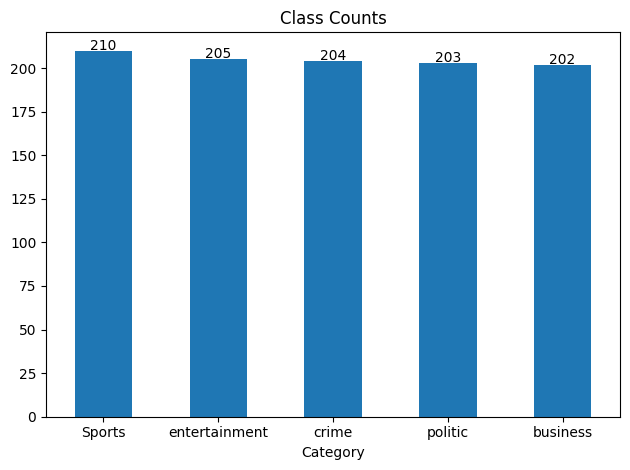

In [2]:
# ---- Reproducibility ----
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ---- Load Dataset ----
DATA_PATH = "Data/Burmese_News_Dataset.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH not found: {DATA_PATH}")

df = pd.read_csv(DATA_PATH, encoding="utf-8")

# Keep only what I need and clean up
df = df[["News", "Category"]].copy()
df["News"] = df["News"].astype(str).str.strip() # Convert to strings and trim whitespace to avoids surprises like integers/NaNs sneaking in as types.
df["Category"] = df["Category"].astype(str).str.strip()

# Drop empty / null
df = df.replace({"News": {"": np.nan}}).dropna(subset=["News", "Category"]).reset_index(drop=True)

print("Shape:", df.shape)
print(df.head(3))

# ----- Class distribution -----
counts = df["Category"].value_counts()
print("\nClass distribution:")
print(counts)

ax = counts.plot(kind="bar", rot=0, title="Class Counts")
for i, v in enumerate(counts.values):
    plt.text(i, v + 0.5, str(v), ha="center")
plt.tight_layout() # to prevent label cut-offs.
plt.show()

## Step 2: Data Preprocessing

#### Tokenization, Unicode Normalization and Stopword Removal

In [3]:
# %pip install pyidaungsu scikit-learn joblib

### Load custom Burmese stopwords and integrate with tokenizer
STOPWORDS_FILE = "stopwords.txt"
def load_stopwords(path):
    import os, unicodedata
    sw = set()
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            for line in f:
                w = unicodedata.normalize("NFC", line.strip().lower())  # Unicode normalization
                if w:  # skip blanks
                    sw.add(w)
        print(f"Loaded {len(sw)} stopwords from: {path}")
    else:
        print(f"WARNING: stopwords file not found at {path}. Proceeding without stopword removal.")
    return sw

STOPWORDS = load_stopwords(STOPWORDS_FILE)

### Text cleaning + tokenization 
'''
My Regex explanation: finds all runs of whitespace characters
 - \s → matches any whitespace (spaces, tabs, newlines).
 - \u00A0 → matches the non-breaking space (common in copied text, HTML, PDFs).
 - + → matches one or more in a row. 
'''
_WHITESPACE_RE = re.compile(r"[\s\u00A0]+")

def normalize_unicode(text: str) -> str:
    return unicodedata.normalize("NFC", text or "")

def clean_text(text: str) -> str:
    t = normalize_unicode(text)
    t = _WHITESPACE_RE.sub(" ", t).strip() # To replace all runs of whitespace with a single space.
    return t

def tokenize_burmese(text: str) -> list[str]:
    t = clean_text(text)
    toks = pds.tokenize(t, form="word")   # To do the burmese word segmentation using pyidaungsu library
    toks = [tok.lower().strip() for tok in toks if tok.strip()] # Lowercase tokens (I belive it will be useful for mixed English)
    # To remove custom stopwords
    if STOPWORDS:
        toks = [tok for tok in toks if tok not in STOPWORDS]
    return toks




Loaded 395 stopwords from: stopwords.txt


#### Select Features and Target

In [4]:
# --- Train/Test split (stratified) ---
X = df["News"].astype(str).values
y = df["Category"].astype(str).values

X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")

Train size: 819 | Test size: 205


## Step 3: Model Training

#### Baseline pipeline: TF-IDF (uni/bi-grams) + Naive Bayes


[NB] Accuracy:  0.8634
[NB] Macro-F1:  0.8606

Classification Report (NB):
               precision    recall  f1-score   support

       Sports       0.84      0.64      0.73        42
     business       0.89      0.97      0.93        40
        crime       0.83      0.95      0.89        41
entertainment       0.81      0.85      0.83        41
      politic       0.95      0.90      0.93        41

     accuracy                           0.86       205
    macro avg       0.86      0.87      0.86       205
 weighted avg       0.86      0.86      0.86       205



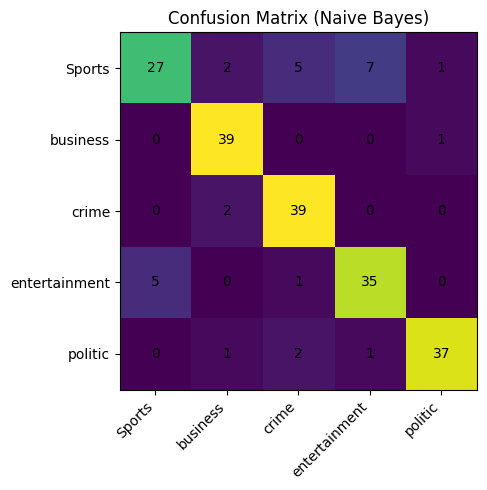

Saved -> nb_tfidf.joblib


In [5]:
### Baseline pipeline: TF-IDF (uni/bi-grams) + Naive Bayes ###
nb_pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(
            tokenizer = tokenize_burmese,
            token_pattern = None, # since I am using my custom tokenizer, I just set as 'None' to avoid warning msg.
            ngram_range = (1, 2),
            min_df = 3,
            max_df = 0.95
        )),
        ("clf", MultinomialNB())
    ])

nb_pipeline.fit(X_train, y_train)
nb_preds = nb_pipeline.predict(X_test)

# --- Metrics ---
nb_acc = accuracy_score(y_test, nb_preds)
nb_f1  = f1_score(y_test, nb_preds, average="macro")
print(f"\n[NB] Accuracy:  {nb_acc:.4f}")
print(f"[NB] Macro-F1:  {nb_f1:.4f}\n")
print("Classification Report (NB):")
print(classification_report(y_test, nb_preds))

### Confusion matrix plot ###
classes = sorted(df["Category"].unique())
cm = confusion_matrix(y_test, nb_preds, labels=classes)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix (Naive Bayes)")
ax.set_xticks(range(len(classes))); ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_yticks(range(len(classes))); ax.set_yticklabels(classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

# --- Save baseline for later inference ---
joblib.dump(nb_pipeline, "models/nb_tfidf.joblib")
print("Saved -> nb_tfidf.joblib")

#### BiLSTM Model

##### Prepare data (Tokenize → sequences → pad (train/test))

In [6]:
##### Prepare data (Tokenize → sequences → pad (train/test))

#  Tokenized texts -> sequences -> pad 

# 1) Prepare tokenized text and join them
train_tok_texts = [" ".join(tokenize_burmese(t)) for t in X_train]
test_tok_texts  = [" ".join(tokenize_burmese(t)) for t in X_test]

# 2) Label encode -> one-hot
# LabelEncoder creates a stable mapping (e.g., Business -> 0, Politics -> 1, …).
# One-hot targets are required by softmax + categorical cross-entropy.
le = LabelEncoder() 
y_train_idx = le.fit_transform(y_train)
y_test_idx  = le.transform(y_test)
num_classes = len(le.classes_)
Y_train = to_categorical(y_train_idx, num_classes=num_classes)
Y_test  = to_categorical(y_test_idx,  num_classes=num_classes)

# 3) Build a Keras tokenizer on TRAIN only
'''
 - Fit on train only to avoid test leakage.
 - oov_token maps unseen words at inference to <unk> so the model won't crash.
 - MAX_TOKENS = 40000 caps vocab size to keep the model compact.
'''
MAX_TOKENS = 40000
tok = Tokenizer(num_words=MAX_TOKENS, oov_token="<unk>")
tok.fit_on_texts(train_tok_texts)

# 4) Text --> Integer Sequences
# Each token becomes its index in the vocab (1..MAX_TOKENS).
# Replaces each token with its vocab index (1..num_words-1). Tokens outside the top num_words become <unk>.
Xtr_seq = tok.texts_to_sequences(train_tok_texts)
Xte_seq = tok.texts_to_sequences(test_tok_texts)

# 5) Sequence length + padding
# lengths = [len(s) for s in Xtr_seq]
# p95 = int(np.percentile(lengths, 95))
# MAX_LEN = int(min(300, max(120, p95)))
# print(f"95th percentile len = {p95} | Using MAX_LEN = {MAX_LEN}")

MAX_LEN = 350  # Fixed length so batches are rectangular tensors.
print(f"Using MAX_LEN = {MAX_LEN}")

# post padding/truncation keeps the earliest tokens (often most informative for news).
Xtr = pad_sequences(Xtr_seq, maxlen=MAX_LEN, padding="post", truncating="post")
Xte = pad_sequences(Xte_seq, maxlen=MAX_LEN, padding="post", truncating="post")

# 6) Vocab size (no custom emb_matrix; we’ll use Keras default init)
vocab_size = min(MAX_TOKENS, len(tok.word_index) + 1)
print("Vocab size (capped):", vocab_size, "| Train:", Xtr.shape, "| Test:", Xte.shape)

EMB_DIM = 300  # keep your chosen embedding dimension


Using MAX_LEN = 350
Vocab size (capped): 16709 | Train: (819, 350) | Test: (205, 350)


##### Build, train, and evaluate BiLSTM

Class weights: {'Sports': 0.975, 'business': 1.011111111111111, 'crime': 1.0049079754601227, 'entertainment': 0.998780487804878, 'politic': 1.011111111111111}

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 350)]             0         
                                                                 
 embed (Embedding)           (None, 350, 300)          5012700   
                                                                 
 bidirectional (Bidirection  (None, 350, 256)          439296    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 350, 256)          0         
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                 

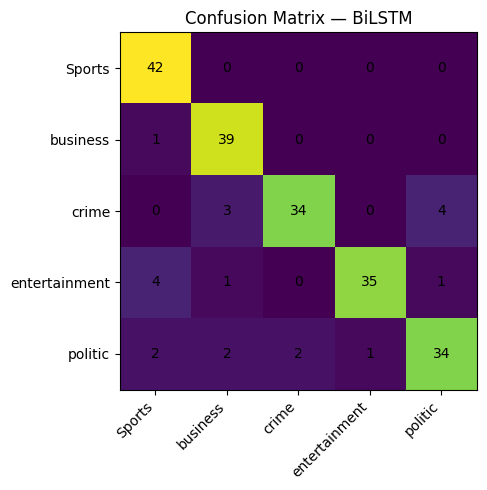

In [7]:
##### Build, train, and evaluate BiLSTM

# 1) Class weights (Gives rarer classes more weight in the loss.)
classes_idx = np.unique(y_train_idx)
cw = compute_class_weight(class_weight="balanced", classes=classes_idx, y=y_train_idx)
class_weight = {int(c): float(w) for c, w in zip(classes_idx, cw)}
print("Class weights:", {le.classes_[k]: v for k, v in class_weight.items()})

# 2) Model 
def build_bilstm(vocab_size, emb_dim, max_len, num_classes):
    inp = layers.Input(shape=(max_len,), dtype="int32")
    emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=emb_dim,
            mask_zero=True,
            name="embed"
        )(inp)

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(emb)
    x = layers.Dropout(0.35)(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.35)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

lstm_model = build_bilstm(vocab_size, EMB_DIM, MAX_LEN, num_classes)
lstm_model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, min_lr=0.00001),
]

history = lstm_model.fit(
    Xtr, Y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

# 3) Evaluate
test_loss, test_acc = lstm_model.evaluate(Xte, Y_test, verbose=0)
y_prob = lstm_model.predict(Xte, verbose=0)
y_pred = y_prob.argmax(axis=1) # predicted class index
y_true = Y_test.argmax(axis=1) # true class index 

print(f"\n[BiLSTM] Accuracy:  {test_acc:.4f}")
print(f"[BiLSTM] Macro-F1:  {f1_score(y_true, y_pred, average='macro'):.4f}\n")
print("Classification Report (BiLSTM):")
print(classification_report(y_true, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred, labels=range(len(le.classes_)))
fig, ax = plt.subplots(figsize=(6,5))
ax.imshow(cm, interpolation="nearest")
ax.set_title("Confusion Matrix — BiLSTM")
ax.set_xticks(range(len(le.classes_))); ax.set_xticklabels(le.classes_, rotation=45, ha="right")
ax.set_yticks(range(len(le.classes_))); ax.set_yticklabels(le.classes_)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()


## Step 4: Save artifacts

In [8]:
# --- save models ---
tf.keras.models.save_model(lstm_model, "models/bilstm_mynews.keras")
with open("models/keras_tokenizer.pkl","wb") as f: pickle.dump(tok, f)
with open("models/label_encoder.pkl","wb") as f: pickle.dump(le, f)

# --- config reflects the new padding length ---
cfg = {"MAX_LEN": 350, "classes": list(le.classes_)}
with open("models/config.json","w",encoding="utf-8") as f:
    json.dump(cfg, f, ensure_ascii=False, indent=2)

# --- save NB baseline too ---
joblib.dump(nb_pipeline, "models/nb_tfidf.joblib")

# --- record metrics on the held-out test set ---
nb_preds = nb_pipeline.predict(X_test)
nb_metrics = {
    "accuracy": float(accuracy_score(y_test, nb_preds)),
    "macro_f1": float(f1_score(y_test, nb_preds, average="macro"))
}

dl_prob = lstm_model.predict(Xte, verbose=0)
dl_metrics = {
    "accuracy": float((dl_prob.argmax(1) == Y_test.argmax(1)).mean()),
    "macro_f1": float(f1_score(Y_test.argmax(1), dl_prob.argmax(1), average="macro"))
}

with open("models/metrics.json","w",encoding="utf-8") as f:
    json.dump({"nb": nb_metrics, "bilstm": dl_metrics}, f, ensure_ascii=False, indent=2)

print("Saved models + config + metrics to ./models/")
print("NB:", nb_metrics)
print("BiLSTM:", dl_metrics)


Saved models + config + metrics to ./models/
NB: {'accuracy': 0.8634146341463415, 'macro_f1': 0.8605996255996257}
BiLSTM: {'accuracy': 0.8975609756097561, 'macro_f1': 0.896586354821649}


## Step 5: Single-text inference (both models)

In [12]:
# Preprocessing helpers
_WS = re.compile(r"[\s\u00A0]+")
def _norm(t): return unicodedata.normalize("NFC", t or "")
def _clean(t): return _WS.sub(" ", _norm(t)).strip()
def tokenize_burmese(t):
    toks = pds.tokenize(_clean(t), form="word")
    return [x.lower().strip() for x in toks if x.strip()]

class BurmeseNewsPredictor:
    def __init__(self, models_dir="models"):
        self.nb = joblib.load(os.path.join(models_dir, "nb_tfidf.joblib"))
        self.model = tf.keras.models.load_model(os.path.join(models_dir, "bilstm_mynews.keras"), compile=False)
        self.tok = pickle.load(open(os.path.join(models_dir, "keras_tokenizer.pkl"), "rb"))
        self.le  = pickle.load(open(os.path.join(models_dir, "label_encoder.pkl"), "rb"))
        self.cfg = json.load(open(os.path.join(models_dir, "config.json"), "r", encoding="utf-8"))
        self.max_len = int(self.cfg["MAX_LEN"])

    def predict_nb(self, text):
        #print(self.nb)
        proba = self.nb.predict_proba([text])[0]
        #print(proba)
        i = int(np.argmax(proba))
        return self.nb.classes_[i], float(proba[i])

    def predict_bilstm(self, text):
        toks = " ".join(tokenize_burmese(text))
        seq = self.tok.texts_to_sequences([toks])
        pad = pad_sequences(seq, maxlen=self.max_len, padding="post", truncating="post")
        probs = self.model.predict(pad, verbose=0)[0]
        i = int(np.argmax(probs))
        return self.le.classes_[i], float(probs[i])

# To make test
pred = BurmeseNewsPredictor()
print(pred.predict_bilstm("အားကစား ပြိုင်ပွဲတွင် အသင်းက ချန်ပီယံ ရရှိခဲ့သည်။"))
print(pred.predict_nb("အားကစား ပြိုင်ပွဲတွင် အသင်းက ချန်ပီယံ ရရှိခဲ့သည်။"))
print("\n")
print(pred.predict_bilstm("စိတ်ကျရောဂါ နှင့် ကွန်ပျူတာ သုံးစွဲမှု ပေါ်လစီ အစိုးရက အသစ်ထုတ်ပြန်ရှိ"))
print(pred.predict_nb("စိတ်ကျရောဂါ နှင့် ကွန်ပျူတာ သုံးစွဲမှု ပေါ်လစီ အစိုးရက အသစ်ထုတ်ပြန်ရှိ"))
print("\n")
print(pred.predict_bilstm("တိုက်ပွဲများ ပြင်းထန်နေခြင်းတို့နှင့်အတူ မြန်မာနိုင်ငံ၌ ဖြစ်ပွားနေသည့် ပဋိပက္ခသည် အာဆီယံအတွက် ကိုင်တွယ်ဖြေရှင်းရန် ခက်ခဲသော ပြဿနာဖြစ်နေခဲ့ကြောင်း ဖိလစ်ပိုင်သမ္မတ ဖာဒီနန်မားကို့စ်က ပြောကြားသည်။"))
print(pred.predict_nb("တိုက်ပွဲများ ပြင်းထန်နေခြင်းတို့နှင့်အတူ မြန်မာနိုင်ငံ၌ ဖြစ်ပွားနေသည့် ပဋိပက္ခသည် အာဆီယံအတွက် ကိုင်တွယ်ဖြေရှင်းရန် ခက်ခဲသော ပြဿနာဖြစ်နေခဲ့ကြောင်း ဖိလစ်ပိုင်သမ္မတ ဖာဒီနန်မားကို့စ်က ပြောကြားသည်။"))


('Sports', 0.7470835447311401)
('Sports', 0.4527711786775616)


('Sports', 0.28068408370018005)
('business', 0.25222589738119056)


('politic', 0.5012542605400085)
('politic', 0.5472996689983488)


In [10]:
def run_batch(input_csv, output_csv, text_col="News", model="bilstm"):
    pred = BurmeseNewsPredictor()
    df = pd.read_csv(input_csv)
    texts = df[text_col].astype(str).tolist()
    if model in ("nb","both"):
        nb = [pred.predict_nb(t) for t in texts]
        df["nb_label"] = [x[0] for x in nb]; df["nb_conf"] = [x[1] for x in nb]
    if model in ("bilstm","both"):
        dl = [pred.predict_bilstm(t) for t in texts]
        df["bilstm_label"] = [x[0] for x in dl]; df["bilstm_conf"] = [x[1] for x in dl]
    df.to_csv(output_csv, index=False); print("Saved ->", output_csv)


In [11]:
run_batch("Data/Burmese_News_Dataset.csv", "Data/Burmese_News_Dataset_Result.csv", text_col="News", model="both")

Saved -> Data/Burmese_News_Dataset_Result.csv
